## Анализ эффективности удержания клиентов

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)

- mes_estim — оценка интенсивности пользования интернет мессенджерами
- churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [2]:
churn = pd.read_csv('churn_analysis.csv', index_col=0)
churn.shape

(3333, 22)

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           3333 non-null   object 
 1   account_length  3333 non-null   int64  
 2   area_code       3333 non-null   int64  
 3   intl_plan       3333 non-null   object 
 4   vmail_plan      3333 non-null   object 
 5   vmail_message   3333 non-null   int64  
 6   day_mins        3333 non-null   float64
 7   day_calls       3333 non-null   int64  
 8   day_charge      3333 non-null   float64
 9   eve_mins        3333 non-null   float64
 10  eve_calls       3333 non-null   int64  
 11  eve_charge      3333 non-null   float64
 12  night_mins      3333 non-null   float64
 13  night_calls     3333 non-null   int64  
 14  night_charge    3333 non-null   float64
 15  intl_mins       3333 non-null   float64
 16  intl_calls      3333 non-null   int64  
 17  intl_charge     3333 non-null   f

In [4]:
churn.describe()

,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.990999,0.484236
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.819138,0.138560
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.390000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,1.000000,0.480000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,2.000000,0.580000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,2.000000,0.960000


In [5]:
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


#### 1. Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции: <center><code>scipy.stats.chi2_contingency(subtable, correction=False)</code></center>

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [6]:
states = np.unique(churn.state)
states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [7]:
control = churn[churn.treatment == 1]
contingency_table = pd.crosstab(control.churn, control.state)

contingency_table

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [8]:
print(f'p-value for contingency_table: {stats.chi2_contingency(contingency_table, correction=False)[1]}')

p-value for contingency_table: 0.709759004277847


In [9]:
p_values = []
for index_1, state_1 in enumerate(states):
    for index_2, state_2 in enumerate(states):
        
        if index_1 >= index_2:
            continue          
          
        p = stats.chi2_contingency(contingency_table.iloc[:, [index_1, index_2]], correction=False)
        p_values.append(p[1])

print(f'Number of p-values < 0.05: {sum([p < 0.05 for p in p_values])}')
print(f'Mean of p-values without correction: {np.mean(p_values)}')

Number of p-values < 0.05: 34
Mean of p-values without correction: 0.5018273798739158


#### 2. В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так: $$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции <code>scipy.stats.chi2_contingency</code>) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией.

In [10]:
p_values = []
for index_1, state_1 in enumerate(states):
    for index_2, state_2 in enumerate(states):
        
        if index_1 >= index_2:
            continue          
          
        p = stats.chi2_contingency(contingency_table.iloc[:, [index_1, index_2]], correction=True)
        p_values.append(p[1])

print(f'Number of p-values < 0.05 with Yates correction: {sum([p < 0.05 for p in p_values])}')
print(f'Mean of p-values with Yates correction: {np.mean(p_values)}')

Number of p-values < 0.05 with Yates correction: 0
Mean of p-values with Yates correction: 0.6640566382051047


#### 3. Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

|     | Группа 1 | Группа 2 | $\Sigma$ |
|:---:|:--------:|:--------:|:--------:|
| Воздействие 1 | $a$ | $b$ | $a+b$ |
| Воздействие 2| $c$ | $d$ | $c+d$|
| $\Sigma$ | $a+c$ | $b+d$ | $n=a+b+c+d$ |

Тогда вероятность получить именно такие $a,b,c,d$ при фиксированных значениях сумм по строкам и по столбцам задается выражением:

$$p={\frac {\displaystyle {{a+b} \choose {a}}\displaystyle {{c+d} \choose {c}}}{\displaystyle {{n} \choose {a+c}}}}={ \dfrac {(a+b)!~(c+d)!~(a+c)!~(b+d)!}{a!~~b!~~c!~~d!~~n!}}$$

В числителе этой дроби стоит суммарное количество способов выбрать $a$ и $c$ из $a+b$ и $c+d$ соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца $a+c$ из общего количества рассматриваемых объектов $n$.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения $a,b,c,d$, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора $a,b,c,d$ нужно вычислить значение $p_i$ по формуле выше и просуммировать все такие значения $p_i$ , которые меньше или равны $p$, которое мы вычислили по наблюдаемым значениям $a,b,c,d$.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы $n\times m$.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции, которая принимает на вход таблицу сопряженности 2x2:

<center><code>scipy.stats.fisher_exact</code></center>




In [11]:
p_values = []
for index_1, state_1 in enumerate(states):
    for index_2, state_2 in enumerate(states):
        
        if index_1 >= index_2:
            continue          

        oddsratio, p = stats.fisher_exact(contingency_table.iloc[:, [index_1, index_2]])
        p_values.append(p)

print(f'Number of p-values < 0.05 calculated with Fisher exact test: {sum([p < 0.05 for p in p_values])}')
print(f'Mean of p-values calculated with Fisher exact test: {np.mean(p_values)}')

Number of p-values < 0.05 calculated with Fisher exact test: 10
Mean of p-values calculated with Fisher exact test: 0.6483383060020681


#### 4. Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

In [12]:
stats.pearsonr(churn.day_calls, churn.mes_estim)

(-0.05179435058757264, 0.0027798836869738384)

#### 5. Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [13]:
stats.spearmanr(churn.day_calls, churn.mes_estim)

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

#### 6. Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

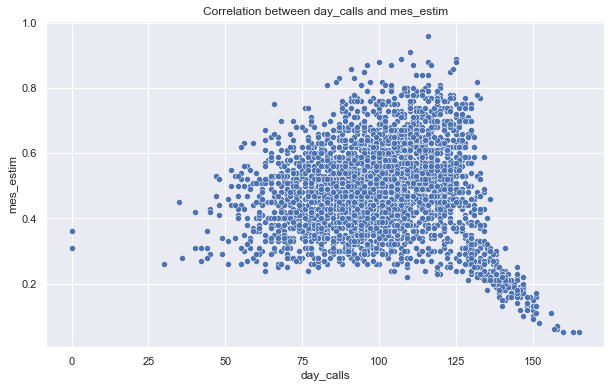

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='day_calls', y='mes_estim', data=churn)
plt.title('Correlation between day_calls and mes_estim')
plt.show()

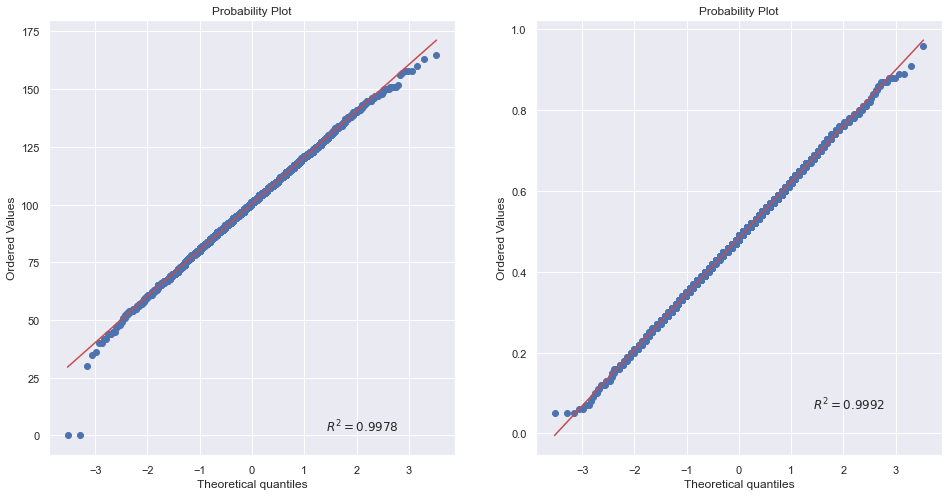

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
stats.probplot(churn.day_calls, dist='norm', plot=plt, rvalue=True)
plt.subplot(1,2,2)
stats.probplot(churn.mes_estim, dist='norm', plot=plt, rvalue=True)
plt.show()

#### 7. Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [16]:
def cramer_coef(contingency_table):
    
    chi_2_stat = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    return np.sqrt(chi_2_stat / (n * (min(contingency_table.shape) - 1)))

print(f'Cramer coefficient value: {cramer_coef(contingency_table.values)}')
print(f'p-value for contingency_table: {stats.chi2_contingency(contingency_table, correction=False)[1]}')

Cramer coefficient value: 0.2003932150203332
p-value for contingency_table: 0.709759004277847


#### 8.  Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !

In [17]:
churn['churn'] = churn['churn'].apply(lambda x: 1 if x == 'True.' else 0)

treatment_0 = churn[churn.treatment == 0].churn
treatment_2 = churn[churn.treatment == 2].churn

treatment_1 = churn[churn.treatment == 1].churn

print(f'Churn proportion for treatment 0 group: {sum(treatment_0)/treatment_0.shape[0]}')
print(f'Churn proportion for treatment 2 group: {sum(treatment_2)/treatment_2.shape[0]}')

print(f'Churn proportion for treatment 1 group: {sum(treatment_1)/treatment_1.shape[0]}')

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    
    P = float(p1 * n1 + p2 * n2) / (n1 + n2)
    
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
    
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

Churn proportion for treatment 0 group: 0.14563106796116504
Churn proportion for treatment 2 group: 0.12511332728921123
Churn proportion for treatment 1 group: 0.1640838650865998


In [18]:
p_0_1 = proportions_diff_z_test(treatment_0, treatment_1)
print(f'95% confidence interval for treatments 0 and 1: {proportions_diff_confint_ind(treatment_0, treatment_1)}, p-value: {p_0_1:.4f}')

p_0_2 = proportions_diff_z_test(treatment_0, treatment_2)
print(f'95% confidence interval for treatments 0 and 2: {proportions_diff_confint_ind(treatment_0, treatment_2)}, p-value: {p_0_2:.4f}')

p_1_2 = proportions_diff_z_test(treatment_1, treatment_2)
print(f'95% confidence interval for treatments 1 and 2: {proportions_diff_confint_ind(treatment_1, treatment_2)}, p-value: {p_1_2:.4f}')

95% confidence interval for treatments 0 and 1: (-0.04848883584089464, 0.011583241590025106), p-value: 0.2283
95% confidence interval for treatments 0 and 2: (-0.007820886720395197, 0.04885636806430281), p-value: 0.1564
95% confidence interval for treatments 1 and 2: (0.00961876673809212, 0.06832230885668503), p-value: 0.0093


In [19]:
multipletests(np.array([p_0_1, p_0_2, p_1_2]), alpha = 0.05, method='fdr_bh')[1]

array([0.22833116, 0.22833116, 0.02804425])